In [22]:
import os
import pandas as pd

In [23]:
# Get the directory with the notebooks, including its subdirectories
current_dir = os.getcwd()

# Get the directories with data and results
data_dir = os.path.join(current_dir, "data/debloating")
temporary_dir= os.path.join(current_dir, "temporary_data")
results_dir = os.path.join(current_dir, "results")

project_dir = os.path.dirname(current_dir)

In [24]:
# Using this function, the purpose is to cancatenate all generated measurements for each repeated experiment 
def concatenate_csv_files(directory_path, output_file):
    file_list = os.listdir(directory_path)
    csv_files = [file for file in file_list if file.endswith(".csv")]

    if not csv_files:
        print("No CSV files found in the directory.")
        return

    dfs = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path, delimiter=';') # This is important, the delimiter
        
        filename_parts = file[:-4].split("_")  # Split filename and remove ".csv" extension        
        df['Program'] = filename_parts[0].split("-")[0]
        df['TestNr'] = filename_parts[0].split("-")[1]
        df['Utilities'] = filename_parts[1]
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_csv(output_file, index=False, sep=';')  # Use semicolon as delimiter

    print(f"CSV files concatenated and saved to '{output_file}'.")

# All data into files in the folder save in a new CSV file
input_data = os.path.join(data_dir, 'repeat10/') # You need to change this for each new folder that you want to concatenate its files
output_data = os.path.join(results_dir, 'cat_repeat10.csv') # You need to change this for each new folder given above

concatenate_csv_files(input_data, output_data)

CSV files concatenated and saved to '/home/rlefeuvr/Documents/Workspace/Debloat/bloat-energy-consumption/notebooks/results/cat_repeat10.csv'.


In [25]:
# Using this function, the purpose is to concatenate all resulting files from all 5 executions
def concatenate_allcsv_files(directory_path, output_file):
    file_list = os.listdir(directory_path)
    csv_files = [file for file in file_list if file.endswith(".csv")]

    if not csv_files:
        print("No CSV files found in the directory.")
        return

    dfs = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path, delimiter=';') # This is important, the delimiter
        df['Repetition'] = file  # Add filename as a new column
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_csv(output_file, index=False, sep=';')  # Use semicolon as delimiter


    print(f"CSV files concatenated and saved to '{output_file}'.")

# Save in a new CSV file
output_alldata = os.path.join(results_dir, 'cat_all_repeats.csv')

concatenate_allcsv_files(temporary_dir, output_alldata)

CSV files concatenated and saved to '/home/rlefeuvr/Documents/Workspace/Debloat/bloat-energy-consumption/notebooks/results/cat_all_repeats.csv'.


In [26]:
# Now we need to find the average value of PSYS for all measurements of a program 
def calculate_average_PSYS(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, delimiter=';')
    
    # Calculate average of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    average_psys = df.groupby(['Program', 'Utilities'])['PSYS'].mean().reset_index()
    
    # Write the average values to a new file separated with a semicolon
    average_psys.to_csv(output_file, index=False, sep=';')
    
    print(f"Average PSYS values written to '{output_file}'.")

# Required inputs and outputs
input_data = os.path.join(results_dir, 'cat_all_repeats.csv')
output_data = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')

calculate_average_PSYS(input_data, output_data)


Average PSYS values written to '/home/rlefeuvr/Documents/Workspace/Debloat/bloat-energy-consumption/notebooks/results/averagePSYS_all_repeats.csv'.


In [27]:
def calculate_average_and_std_PSYS(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, delimiter=';')
    
    # Convert 'PSYS' values from microjoules to joules
    # df['PSYS'] = df['PSYS'] / 1000000  # 1 microjoule = 1e-6 joules

    # Calculate average of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    average_psys = df.groupby(['Program', 'Utilities'])['PSYS'].mean().reset_index()
    average_psys['PSYS'] = average_psys['PSYS'].round(2)  # Round the average values to 2 decimals

    # Calculate standard deviation of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    std_psys = df.groupby(['Program', 'Utilities'])['PSYS'].std().reset_index()
    std_psys['PSYS'] = std_psys['PSYS'].round(2)  # Round the standard deviation values to 2 decimals
    
    # Merge the average and standard deviation DataFrames based on 'Program' and 'Utilities' columns
    result_df = pd.merge(average_psys, std_psys, on=['Program', 'Utilities'], suffixes=('_avg', '_std'))

    # Write the average and standard deviation values to a new file separated with a semicolon
    result_df.to_csv(output_file, index=False, sep=';')

    print(f"Average PSYS and STD values written to '{output_file}'.")

# Required inputs and outputs
input_data = os.path.join(results_dir, 'cat_all_repeats.csv')
output_data = os.path.join(results_dir, 'averagePSYS_with_std_all_repeats.csv')

calculate_average_and_std_PSYS(input_data, output_data)

Average PSYS and STD values written to '/home/rlefeuvr/Documents/Workspace/Debloat/bloat-energy-consumption/notebooks/results/averagePSYS_with_std_all_repeats.csv'.


In [45]:
import pandas as pd

# Required inputs and outputs
input_data = os.path.join(results_dir, 'averagePSYS_with_std_all_repeats.csv')
output_data = os.path.join(results_dir, 'averagePSYS_with_std_all_repeats_pivot.csv')

data = pd.read_csv(input_data, sep=';')

# Pivot the data to create new columns for GNU, ToyBox, and BusyBox
pivoted_data = data.pivot(index='Program', columns='Utilities', values=['PSYS_avg', 'PSYS_std'])

# Flatten the multi-level column index
pivoted_data.columns = [f'{col[0]}_{col[1]}' for col in pivoted_data.columns]

# Reset the index to make 'Program' a regular column again
pivoted_data = pivoted_data.reset_index()

pivoted_data.to_csv(output_data, index=False, sep=';')

In [46]:
# Now we need to find the average value of PSYS and DURATION for all measurements of a program 
def calculate_average_PSYS_DURATION(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, delimiter=';')
    
    # Calculate average of 'PSYS' column for each unique combination of 'Program' and 'Utilities'
    average_psys = df.groupby(['Program', 'Utilities'])['PSYS'].mean().reset_index()
    
    # Calculate average of 'DURATION' column for each unique combination of 'Program' and 'Utilities'
    average_duration = df.groupby(['Program', 'Utilities'])['DURATION'].mean().reset_index()
    
    # Merge the two DataFrames based on 'Program' and 'Utilities'
    merged_df = pd.merge(average_psys, average_duration, on=['Program', 'Utilities'])
    
    # Write the average values to a new file separated with a semicolon
    merged_df.to_csv(output_file, index=False, sep=';')
    
    print(f"Average PSYS and DURATION values written to '{output_file}'.")

# Required inputs and outputs
input_data = os.path.join(results_dir, 'cat_all_repeats.csv')
output_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')

calculate_average_PSYS_DURATION(input_data, output_data)

Average PSYS and DURATION values written to '/home/rlefeuvr/Documents/Workspace/Debloat/bloat-energy-consumption/notebooks/results/averageDURATION_all_repeats.csv'.


In [47]:
# After we need to put together the PSYS and Size values for each program in each of the 3 different implementations

csv_with_ec = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')
csv_with_size = os.path.join(project_dir, 'inputs/programs.csv') 
output_file = os.path.join(results_dir, 'all_ec_bsize.csv')

# Read the first CSV file
df1 = pd.read_csv(csv_with_ec, delimiter=';')

# Read the second CSV file
df2 = pd.read_csv(csv_with_size, delimiter=';')

# Merge the two DataFrames based on 'Program' column
merged_df = pd.merge(df1, df2, on='Program')

# Add the 'Size' values for each 'Utilities' based on the Program and fillna with 0 if not found
df1['Size'] = merged_df.apply(lambda row: row[row['Utilities']], axis=1)

# Save the final DataFrame to a new CSV file, including 'Utilities' and 'PSYS' columns
df1.to_csv(output_file, index=False, sep=';')


In [48]:
# After we need to put together the PSYS and number of Configuration Options for each program in each of the 3 different implementations

csv_with_ec = os.path.join(results_dir, 'averagePSYS_all_repeats.csv')
csv_with_size = os.path.join(project_dir, 'inputs/programs_nr_options.csv') 
output_file = os.path.join(results_dir, 'all_ec_options.csv')

# Read the first CSV file
df1 = pd.read_csv(csv_with_ec, delimiter=';')

# Read the second CSV file
df2 = pd.read_csv(csv_with_size, delimiter=';')

# Merge the two DataFrames based on 'Program' column
merged_df = pd.merge(df1, df2, on='Program')

# Add the 'Size' values for each 'Utilities' based on the Program and fillna with 0 if not found
df1['Options'] = merged_df.apply(lambda row: row[row['Utilities']], axis=1)

# Save the final DataFrame to a new CSV file, including 'Utilities' and 'PSYS' columns
df1.to_csv(output_file, index=False, sep=';')


## Correlation Size / Energy

In [32]:
# Now we want to calculate the Peason correlation between the EC and Size 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['Size']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
spearman_df_size = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(spearman_df_size )

           Spearman Correlation   p-value
Utilities                                
BusyBox                0.304741  0.114844
GNU                    0.251232  0.197196
ToyBox                 0.350017  0.067862


/tmp/ipykernel_753229/2210224678.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['Size']))


In [33]:
def merge_correlation_dfs(spearman: pd.DataFrame, pearson: pd.DataFrame) -> pd.DataFrame:
    # Rename columns for clarity
    spearman = spearman.rename(columns={
        'Spearman Correlation': 'Spearman',
        'p-value': 'p-value_s'
    })
    
    pearson = pearson.rename(columns={
        'Pearson Correlation': 'Pearson',
        'p-value': 'p-value_p'
    })
    
    # Merge on index (Utilities)
    merged_df = spearman.merge(pearson, left_index=True, right_index=True)
    
    return merged_df

def print_latex_df(df: pd.DataFrame, filename: str = "output.tex"):
    # Define column format: 'l' for first column, a separator '|', and 'c' for the rest
    column_format = "l| " + "c " * (len(df.columns))

    # Convert DataFrame to LaTeX without index and with correct format
    latex_str = df.to_latex(
        index=True,  # No row index
        float_format=lambda x: f"{x:.2g}",  # Limit float precision
        column_format=column_format.strip(),  # Ensure clean formatting
        escape=False  # Prevent LaTeX escaping
    )

    # Remove any unwanted extra row
    latex_str = latex_str.replace("\\toprule\n &", "\\toprule\n")
    latex_str = latex_str.replace("\\midrule\n &", "\\midrule\n") 
    latex_str = latex_str.replace("Utilities &  &  &  &  \\\\", "")  
    # Make headers bold dynamically

    headers = " & ".join(f"{col}" for col in df.columns)
    headers = df.index.name+" & "+headers
    latex_str = latex_str.replace(" & ".join(df.columns), headers)
    print(latex_str)
    with open(filename, "w") as f:
        f.write(latex_str)


def print_latex_compact_df(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    df3: pd.DataFrame,
    label1: str = "DF1",
    label2: str = "DF2",
    label3: str = "DF3",
    filename: str = "compact_output.tex"
):
    def format_number(x):
        try:
            x = float(x)
            if abs(x) < 1e-3 and x != 0.0:
                return f"{x:.2e}"  # scientific notation
            else:
                return f"{x:.3f}"
        except:
            return str(x)

    def format_df(df):
        df_formatted = df.copy()
        for idx, row in df.iterrows():
            try:
                condition = float(row.iloc[1]) > 0.05
            except:
                condition = False  # fallback if non-numeric

            if condition:
                df_formatted.loc[idx] = row.apply(lambda x: f"\\hatchedCell{{{format_number(x)}}}")
            else:
                df_formatted.loc[idx] = row.apply(lambda x: format_number(x))
        return df_formatted

    df1_fmt = format_df(df1)
    df2_fmt = format_df(df2)
    df3_fmt = format_df(df3)

    # Add \textit{} around the index (utility names)
    df1_fmt.index = [f"\\textit{{{i}}}" for i in df1_fmt.index]
    df2_fmt.index = [f"\\textit{{{i}}}" for i in df2_fmt.index]
    df3_fmt.index = [f"\\textit{{{i}}}" for i in df3_fmt.index]

    combined = pd.concat([df1_fmt, df2_fmt, df3_fmt], axis=1, keys=[label1, label2, label3])
    combined.columns = pd.MultiIndex.from_tuples(combined.columns)

    latex_str = combined.to_latex(
        escape=False,
        multicolumn=True,
        multicolumn_format='c',
        multirow=True,
        index=True,
        column_format="l|cc||cc||cc"
    )

    print(latex_str)
    with open(filename, "w") as f:
        f.write(latex_str)

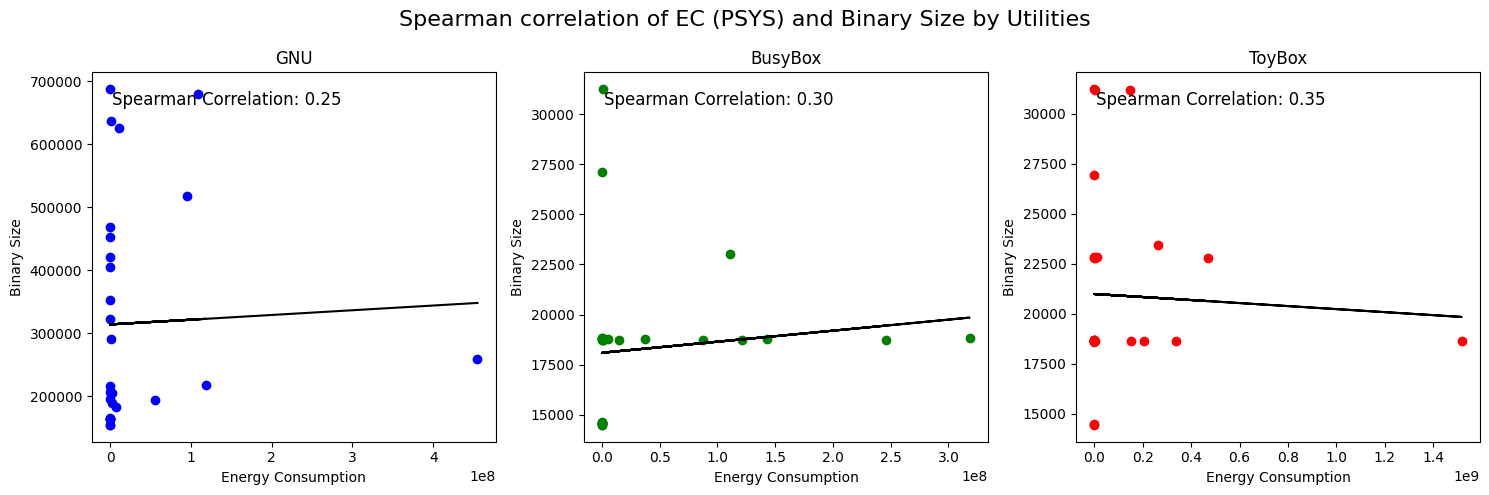

In [41]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_bsize.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Size'] = pd.to_numeric(df['Size'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Size'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Binary Size')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'Size']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Size'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and Binary Size by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

## PSYS / Performance


In [ ]:
# Now we want to calculate the Peason correlation between the EC and Duration 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['DURATION']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
spearman_df_perf = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(spearman_df_perf)

           Spearman Correlation       p-value
Utilities                                    
BusyBox                0.959496  7.983564e-16
GNU                    0.891078  2.070780e-10
ToyBox                 0.965517  1.019583e-16


/tmp/ipykernel_753229/1557892229.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['DURATION']))


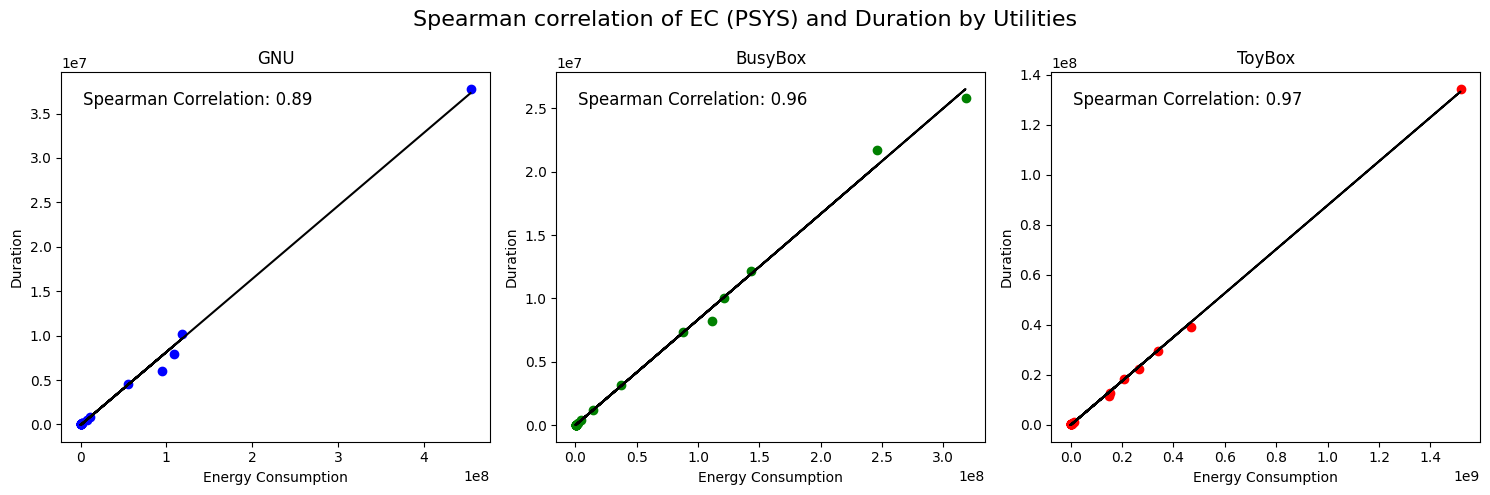

In [42]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'averageDURATION_all_repeats.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['DURATION'] = pd.to_numeric(df['DURATION'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['DURATION'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('Duration')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'DURATION']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['DURATION'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and Duration by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

## Correlation PSYS Nb of Options

In [43]:
# Now we want to calculate the Peason correlation between the EC and Number of Configuration Options 
# for all utilities in each 3 different implementations

# The Spearman correlation with the p-value

import pandas as pd
from scipy.stats import spearmanr

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Calculate Spearman correlation and p-value for each 'Utilities' separately
results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['Options']))

# Extract the correlation coefficients and p-values
correlations = results.apply(lambda x: x.correlation)
p_values = results.apply(lambda x: x.pvalue)

# Combine correlations and p-values into a DataFrame
spearman_df_options = pd.DataFrame({'Spearman Correlation': correlations, 'p-value': p_values})

# Print the correlations and p-values
print(spearman_df_options)

           Spearman Correlation   p-value
Utilities                                
BusyBox                0.270593  0.163709
GNU                    0.460888  0.013575
ToyBox                 0.391512  0.039370


/tmp/ipykernel_753229/386084847.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('Utilities').apply(lambda x: spearmanr(x['PSYS'], x['Options']))


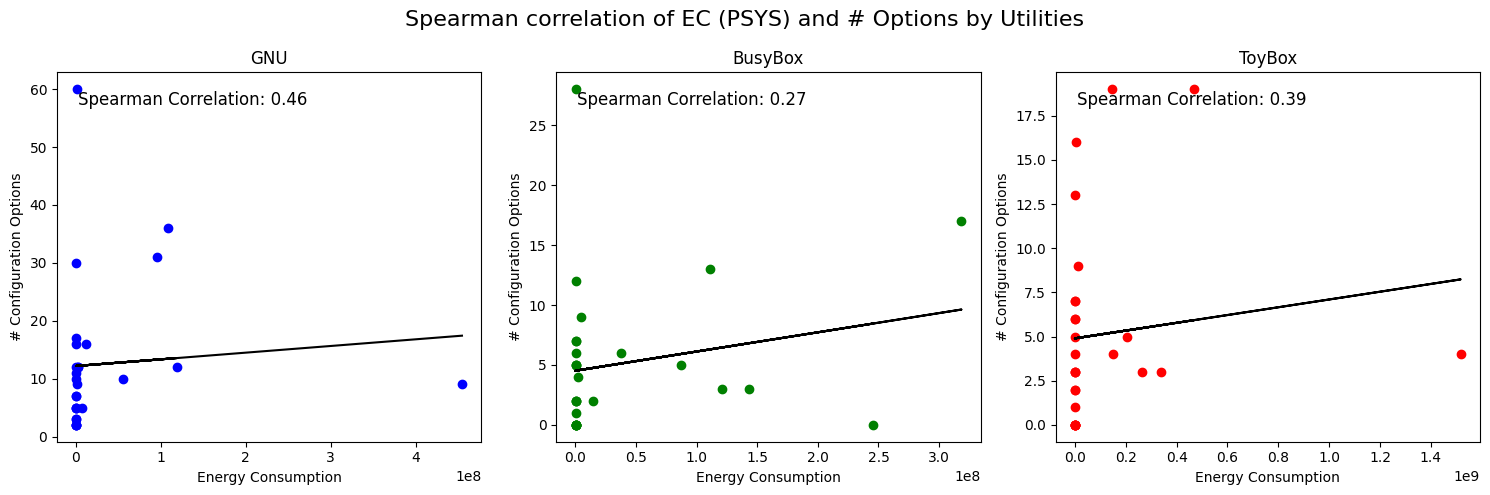

In [ ]:
import pandas as pd
import numpy as np # It's needed for the "trend line"
import matplotlib.pyplot as plt

input_data = os.path.join(results_dir, 'all_ec_options.csv')
# First, we read the data from the CSV file with all experiments into a DataFrame
df = pd.read_csv(input_data, delimiter=";")

# Convert 'PSYS' and 'Size' columns to numeric
df['PSYS'] = pd.to_numeric(df['PSYS'])
df['Options'] = pd.to_numeric(df['Options'])

# Create separate scatter plots for each utility with trend lines
utilities = ['GNU', 'BusyBox', 'ToyBox']
colors = ['blue', 'green', 'red']
fig, axes = plt.subplots(nrows=1, ncols=len(utilities), figsize=(15, 5))

for i, utility in enumerate(utilities):
    utility_df = df[df['Utilities'] == utility]
    axes[i].scatter(utility_df['PSYS'], utility_df['Options'], color=colors[i])
    axes[i].set_xlabel('Energy Consumption')
    axes[i].set_ylabel('# Configuration Options')
    axes[i].set_title(utility)

    # It calculates the Spearman correlation coefficient and show it in the plot
    spearman_corr = utility_df[['PSYS', 'Options']].corr(method='spearman').iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Spearman Correlation: {spearman_corr:.2f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Fit a linear regression line to the data points
    z = np.polyfit(utility_df['PSYS'], utility_df['Options'], 1)
    p = np.poly1d(z)
    axes[i].plot(utility_df['PSYS'], p(utility_df['PSYS']), color='black')

# We set the overall title for all three figures
fig.suptitle('Spearman correlation of EC (PSYS) and # Options by Utilities', fontsize=16)

# We adjust the spacing between subplots
plt.tight_layout()

# Finally, we show the plots
plt.show()

In [50]:
print_latex_compact_df(spearman_df_size,spearman_df_options,spearman_df_perf , label1="Energy/Size", label3="Energy/Perf", label2="Energy/Options",filename=os.path.join(results_dir, "correlation_size.tex"))

\begin{tabular}{l|cc||cc||cc}
\toprule
 & \multicolumn{2}{c}{Energy/Size} & \multicolumn{2}{c}{Energy/Options} & \multicolumn{2}{c}{Energy/Perf} \\
 & Spearman Correlation & p-value & Spearman Correlation & p-value & Spearman Correlation & p-value \\
\midrule
\textit{BusyBox} & \hatchedCell{0.305} & \hatchedCell{0.115} & \hatchedCell{0.271} & \hatchedCell{0.164} & 0.959 & 7.98e-16 \\
\textit{GNU} & \hatchedCell{0.251} & \hatchedCell{0.197} & 0.461 & 0.014 & 0.891 & 2.07e-10 \\
\textit{ToyBox} & \hatchedCell{0.350} & \hatchedCell{0.068} & 0.392 & 0.039 & 0.966 & 1.02e-16 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_753229/4101284551.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\hatchedCell{0.305}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_formatted.loc[idx] = row.apply(lambda x: f"\\hatchedCell{{{format_number(x)}}}")
/tmp/ipykernel_753229/4101284551.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\hatchedCell{0.115}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_formatted.loc[idx] = row.apply(lambda x: f"\\hatchedCell{{{format_number(x)}}}")
/tmp/ipykernel_753229/4101284551.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\hatchedCell{0.271}' has dtype incompatible with float64, please explicitly cast to a compatible dtyp